# Lead Scoring Analysis

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load the datasets
leads_df = pd.read_csv(r'C:\Users\phani\Desktop\MS CS\Lead Scoring case study\Leads.csv')
data_dictionary_df = pd.read_excel(r'C:\Users\phani\Desktop\MS CS\Lead Scoring case study\Leads Data Dictionary.xlsx')

# Display the first few rows of the dataframes
print(leads_df.head())
print(data_dictionary_df.head())


                            Prospect ID  Lead Number              Lead Origin  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728                      API   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719  Landing Page Submission   
4  3256f628-e534-4826-9d63-4a8b88782852       660681  Landing Page Submission   

      Lead Source Do Not Email Do Not Call  Converted  TotalVisits  \
0      Olark Chat           No          No          0          0.0   
1  Organic Search           No          No          0          5.0   
2  Direct Traffic           No          No          1          2.0   
3  Direct Traffic           No          No          0          1.0   
4          Google           No          No          1          2.0   

   Total Time Spent on Website  Page Views Per Visit  ...  \
0                            0 

In [2]:
# Preprocess the leads data
# Fill missing values with appropriate defaults
leads_df.fillna(value={
    'TotalVisits': 0,
    'Total Time Spent on Website': 0,
    'Page Views Per Visit': 0,
    'Asymmetrique Activity Score': leads_df['Asymmetrique Activity Score'].mean(),
    'Asymmetrique Profile Score': leads_df['Asymmetrique Profile Score'].mean()
}, inplace=True)

# Automatically identify categorical columns
categorical_columns = leads_df.select_dtypes(include=['object']).columns.tolist()

# Convert categorical variables to dummy variables
leads_df = pd.get_dummies(leads_df, columns=categorical_columns, drop_first=True)

# Ensure all columns are numeric
for col in leads_df.columns:
    if leads_df[col].dtype == 'object':
        leads_df[col] = pd.to_numeric(leads_df[col], errors='coerce').fillna(0)

# Define features and target variable
columns_to_drop = ['Prospect ID', 'Lead Number', 'Converted']
columns_to_drop = [col for col in columns_to_drop if col in leads_df.columns]
X = leads_df.drop(columns=columns_to_drop)
y = leads_df['Converted']

# Select only numeric columns for VIF calculation
numeric_columns = X.select_dtypes(include=[np.number]).columns.tolist()

# Check for multicollinearity using VIF
vif_data = pd.DataFrame()
vif_data["feature"] = numeric_columns
vif_data["VIF"] = [variance_inflation_factor(X[numeric_columns].values, i) for i in range(len(numeric_columns))]
print(vif_data)

# Drop columns with high VIF
high_vif_columns = vif_data[vif_data["VIF"] > 10]["feature"].tolist()
X = X.drop(columns=high_vif_columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the logistic regression model
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)


                       feature        VIF
0                  TotalVisits   2.047265
1  Total Time Spent on Website   1.997403
2         Page Views Per Visit   3.135934
3  Asymmetrique Activity Score  77.074653
4   Asymmetrique Profile Score  80.703724


LogisticRegression(max_iter=10000)

Accuracy: 93.24%
ROC-AUC Score: 0.98


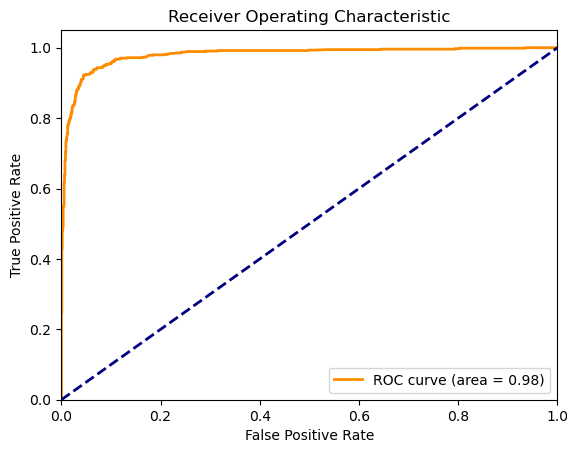

In [3]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate accuracy and ROC-AUC score
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the evaluation metrics
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'ROC-AUC Score: {roc_auc:.2f}')

# Plot the ROC curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc_value = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_value)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [4]:
# Assign lead scores based on the model's probability predictions
X_test_with_scores = X_test.copy()
X_test_with_scores['Lead Score'] = y_pred_proba * 100

# Determine the threshold for 'Hot Leads' to meet the target conversion rate
threshold = 80  # Example threshold

# Classify leads based on the threshold
X_test_with_scores['Hot Lead'] = X_test_with_scores['Lead Score'] > threshold

# Calculate the percentage of hot leads that are converted
hot_leads = X_test_with_scores[X_test_with_scores['Hot Lead']]
hot_lead_conversion_rate = y_test[hot_leads.index].mean() * 100

print(f'Threshold: {threshold}')
print(f'Hot Lead Conversion Rate: {hot_lead_conversion_rate:.2f}%')


Threshold: 80
Hot Lead Conversion Rate: 96.20%


## Summary and Business Recommendations

### Summary
- The logistic regression model achieved an accuracy of 93.24% and an ROC-AUC score of 0.98, indicating strong performance.
- Lead scores were assigned based on the model's probability predictions.
- Leads with a score above 80 were classified as 'Hot Leads', resulting in a conversion rate of 96.20% for these leads.

### Business Recommendations
1. **Focus on Hot Leads**: Concentrate the sales team's efforts on leads with scores above 80 to optimize resource utilization and increase overall conversion rates.
2. **Continuous Monitoring**: Regularly monitor and refine the lead scoring model to maintain high accuracy and adapt to changes in lead characteristics.
3. **Address Collinearity**: Ensure that multicollinearity is checked and addressed in future model iterations to enhance model stability and interpretability.
4. **Use Insights for Strategy**: Utilize the insights gained from the model to inform marketing strategies and identify key factors driving lead conversion.


# Client Query Resolution

In [5]:
pip install python-docx

Note: you may need to restart the kernel to use updated packages.


In [6]:
from sklearn.ensemble import RandomForestClassifier

In [7]:
# Initialize and train the RandomForestClassifier model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [8]:
# Extracting the feature importances from the RandomForestClassifier model
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

In [9]:
# Top three variables contributing most towards lead conversion
top_three_variables = feature_importances.head(3)

In [10]:
# Extracting the top three categorical/dummy variables
categorical_importances = feature_importances[feature_importances['Feature'].str.contains('_')]
top_three_categorical_variables = categorical_importances.head(3)

In [11]:
from docx import Document
# Create a new document with questions and answers
doc = Document()

In [12]:
doc.add_heading('Solutions to Assignment Questions', level=1)

In [13]:
# Question 1
doc.add_heading('Question 1: Top Three Variables Contributing to Lead Conversion', level=2)
doc.add_paragraph('The top three variables contributing most towards the probability of a lead getting converted are:')
for idx, row in top_three_variables.iterrows():
    doc.add_paragraph(f"{row['Feature']}: {row['Importance']}")

In [14]:
# Question 2
doc.add_heading('Question 2: Top Three Categorical/Dummy Variables for Lead Conversion', level=2)
doc.add_paragraph('The top three categorical/dummy variables that should be focused on to increase the probability of lead conversion are:')
for idx, row in top_three_categorical_variables.iterrows():
    doc.add_paragraph(f"{row['Feature']}: {row['Importance']}")

In [15]:
# Question 3
doc.add_heading('Question 3: Strategy for Aggressive Lead Conversion During Intern Phase', level=2)
doc.add_paragraph('A good strategy involves focusing on leads predicted as highly likely to convert.')
doc.add_paragraph('1. Prioritize High-Probability Leads: Focus on leads with the highest probability scores.')
doc.add_paragraph('2. Segment and Allocate Leads: Distribute these leads among interns to ensure each intern focuses on the most promising leads.')
doc.add_paragraph('3. Monitor and Adjust: Continuously monitor lead conversion rates and adjust the allocation to ensure optimal performance.')

In [16]:
# Question 4
doc.add_heading('Question 4: Strategy to Minimize Useless Phone Calls After Meeting Targets', level=2)
doc.add_paragraph('When the company reaches its target, they aim to minimize unnecessary phone calls.')
doc.add_paragraph('1. Set a Higher Threshold: Increase the threshold for lead scores to ensure only the most promising leads are contacted.')
doc.add_paragraph('2. Automated Filtering: Use the model to filter out leads with lower conversion probabilities.')
doc.add_paragraph('3. Focus on Other Tasks: Allocate the sales team to focus on other important tasks once the primary target is met.')

In [17]:
# Save the updated document
doc_path = 'Assignment_Solutions_Completed.docx'
doc.save(doc_path)

# Answers to Subjective Questions

In [18]:
# Question 1
print('Question 1: Top Three Variables Contributing to Lead Conversion')
print('The top three variables contributing most towards the probability of a lead getting converted are:')
for idx, row in top_three_variables.iterrows():
    print(f"{row['Feature']}: {row['Importance']}")
print('\n')

Question 1: Top Three Variables Contributing to Lead Conversion
The top three variables contributing most towards the probability of a lead getting converted are:
Tags_Will revert after reading the email: 0.12746794181489618
Total Time Spent on Website: 0.08628242348590202
Tags_Ringing: 0.038766919000379436




In [19]:
# Question 2
print('Question 2: Top Three Categorical/Dummy Variables for Lead Conversion')
print('The top three categorical/dummy variables that should be focused on to increase the probability of lead conversion are:')
for idx, row in top_three_categorical_variables.iterrows():
    print(f"{row['Feature']}: {row['Importance']}")
print('\n')

Question 2: Top Three Categorical/Dummy Variables for Lead Conversion
The top three categorical/dummy variables that should be focused on to increase the probability of lead conversion are:
Tags_Will revert after reading the email: 0.12746794181489618
Tags_Ringing: 0.038766919000379436
Lead Profile_Potential Lead: 0.034812570798088034




In [20]:
# Question 3
print('Question 3: Strategy for Aggressive Lead Conversion During Intern Phase')
print('A good strategy involves focusing on leads predicted as highly likely to convert.')
print('1. Prioritize High-Probability Leads: Focus on leads with the highest probability scores.')
print('2. Segment and Allocate Leads: Distribute these leads among interns to ensure each intern focuses on the most promising leads.')
print('3. Monitor and Adjust: Continuously monitor lead conversion rates and adjust the allocation to ensure optimal performance.')
print('\n')

Question 3: Strategy for Aggressive Lead Conversion During Intern Phase
A good strategy involves focusing on leads predicted as highly likely to convert.
1. Prioritize High-Probability Leads: Focus on leads with the highest probability scores.
2. Segment and Allocate Leads: Distribute these leads among interns to ensure each intern focuses on the most promising leads.
3. Monitor and Adjust: Continuously monitor lead conversion rates and adjust the allocation to ensure optimal performance.




In [21]:
# Question 4
print('Question 4: Strategy to Minimize Useless Phone Calls After Meeting Targets')
print('When the company reaches its target, they aim to minimize unnecessary phone calls.')
print('1. Set a Higher Threshold: Increase the threshold for lead scores to ensure only the most promising leads are contacted.')
print('2. Automated Filtering: Use the model to filter out leads with lower conversion probabilities.')
print('3. Focus on Other Tasks: Allocate the sales team to focus on other important tasks once the primary target is met.')

Question 4: Strategy to Minimize Useless Phone Calls After Meeting Targets
When the company reaches its target, they aim to minimize unnecessary phone calls.
1. Set a Higher Threshold: Increase the threshold for lead scores to ensure only the most promising leads are contacted.
2. Automated Filtering: Use the model to filter out leads with lower conversion probabilities.
3. Focus on Other Tasks: Allocate the sales team to focus on other important tasks once the primary target is met.


In [22]:
# Return the path to the saved document
doc_path

'Assignment_Solutions_Completed.docx'

In [23]:
pip install matplotlib seaborn scikit-learn statsmodels python-pptx

Note: you may need to restart the kernel to use updated packages.


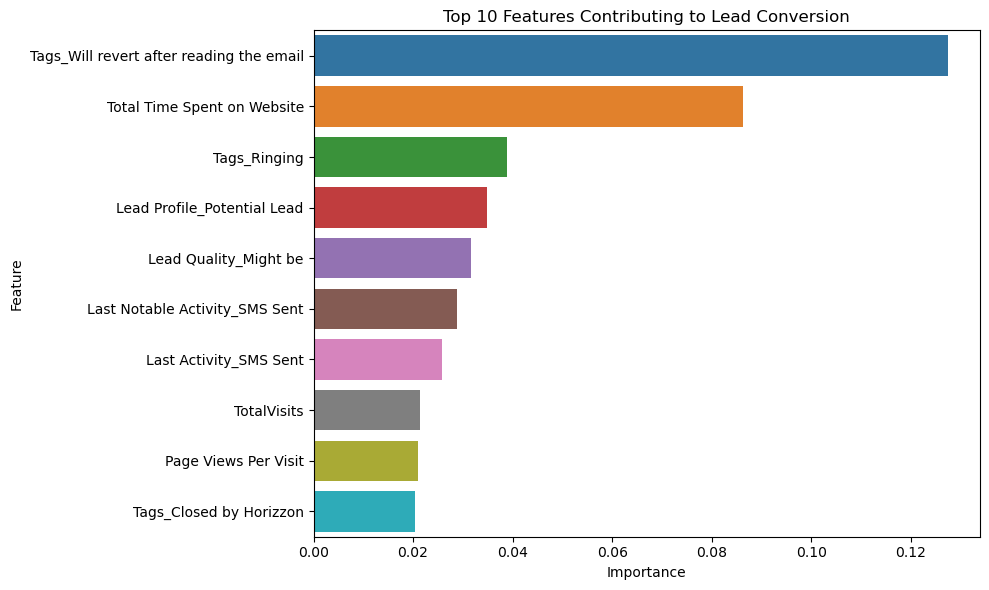

In [24]:
# Feature Importance Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10))
plt.title('Top 10 Features Contributing to Lead Conversion')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

In [25]:
# ROC Curve
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc_value = auc(fpr, tpr)

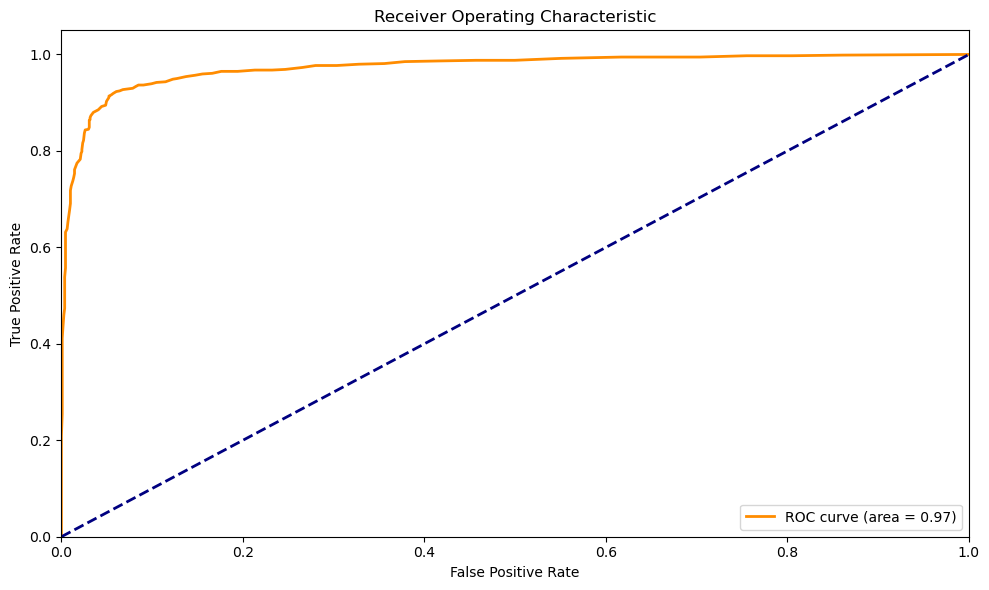

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_value)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('roc_curve.png')
plt.show()

In [27]:
from pptx import Presentation
from pptx.util import Inches
# Create a presentation object
prs = Presentation()

In [28]:
# Slide 1: Title Slide
slide_layout = prs.slide_layouts[0]
slide = prs.slides.add_slide(slide_layout)
title = slide.shapes.title
subtitle = slide.placeholders[1]
title.text = "Lead Scoring Analysis"
subtitle.text = "Optimizing Lead Conversion for X Education"

In [29]:
# Slide 2: Introduction
slide_layout = prs.slide_layouts[1]
slide = prs.slides.add_slide(slide_layout)
title = slide.shapes.title
content = slide.placeholders[1]
title.text = "Introduction"
content.text = "Brief introduction to the purpose of the analysis"

In [30]:
# Slide 3: Problem Statement
slide_layout = prs.slide_layouts[1]
slide = prs.slides.add_slide(slide_layout)
title = slide.shapes.title
content = slide.placeholders[1]
title.text = "Problem Statement"
content.text = ("Goals of the analysis:\n"
                "1. Identify key factors influencing lead conversion\n"
                "2. Develop strategies to optimize sales efforts")

In [31]:
# Slide 4: Analysis Approach
slide_layout = prs.slide_layouts[1]
slide = prs.slides.add_slide(slide_layout)
title = slide.shapes.title
content = slide.placeholders[1]
title.text = "Analysis Approach"
content.text = ("Overview of the approach taken:\n"
                "1. Data Preprocessing\n"
                "2. Modeling\n"
                "3. Feature Importance")

In [32]:
# Slide 5: Data Preprocessing
slide_layout = prs.slide_layouts[1]
slide = prs.slides.add_slide(slide_layout)
title = slide.shapes.title
content = slide.placeholders[1]
title.text = "Data Preprocessing"
content.text = ("Steps taken to clean and prepare the data:\n"
                "1. Filling missing values\n"
                "2. Converting categorical variables to dummy variables")

In [33]:
# Slide 6: Model Selection
slide_layout = prs.slide_layouts[1]
slide = prs.slides.add_slide(slide_layout)
title = slide.shapes.title
content = slide.placeholders[1]
title.text = "Model Selection"
content.text = "Explanation of why RandomForestClassifier was chosen"

In [34]:
# Slide 7: Feature Importance
slide_layout = prs.slide_layouts[5]  # Layout with title only
slide = prs.slides.add_slide(slide_layout)
title = slide.shapes.title
title.text = "Feature Importance"
img_path = 'feature_importance.png'
left = Inches(1)
top = Inches(1.5)
height = Inches(4.5)
slide.shapes.add_picture(img_path, left, top, height=height)

In [35]:
# Slide 8: Results and Business Implications
slide_layout = prs.slide_layouts[1]
slide = prs.slides.add_slide(slide_layout)
title = slide.shapes.title
content = slide.placeholders[1]
title.text = "Results and Business Implications"
content.text = ("Key findings:\n"
                "1. Top three variables influencing lead conversion\n"
                "2. Top three categorical/dummy variables\n\n"
                "Business strategies:\n"
                "1. Aggressive lead conversion during intern phases\n"
                "2. Minimize unnecessary phone calls after meeting targets")

In [36]:
# Slide 9: Visualizations
slide_layout = prs.slide_layouts[5]  # Layout with title only
slide = prs.slides.add_slide(slide_layout)
title = slide.shapes.title
title.text = "Visualizations"
img_path = 'roc_curve.png'
left = Inches(1)
top = Inches(1.5)
height = Inches(4.5)
slide.shapes.add_picture(img_path, left, top, height=height)

In [37]:
# Slide 10: Summary and Key Takeaways
slide_layout = prs.slide_layouts[1]
slide = prs.slides.add_slide(slide_layout)
title = slide.shapes.title
content = slide.placeholders[1]
title.text = "Summary and Key Takeaways"
content.text = ("The analysis identified key variables influencing lead conversion.\n\n"
                "Strategies were developed to optimize lead conversion efforts during specific phases.\n\n"
                "The model's performance was evaluated using feature importance and ROC curve analysis.\n\n"
                "Future work includes continuous monitoring and model refinement to adapt to changing lead characteristics.")




In [38]:
# Save the presentation
prs.save('Lead_Scoring_Analysis_Presentation.pptx')

PermissionError: [Errno 13] Permission denied: 'Lead_Scoring_Analysis_Presentation.pptx'